In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench import save_results, load_results
from ema_workbench import (Model, RealParameter, perform_experiments, ScalarOutcome)
from ema_workbench.analysis import parcoords
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [17]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

For Scenario we ran both the basic with 50k runs and basic espilon and basic reference scenario which is below here.

In [18]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

nfe = 50000
new_levers = levers
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimizer_sven_6.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

espilon = [1e3] * len(dike_model.outcomes)

After the results and analysis of the above setup, we can run the below setup based on the worst case of the previous run and altered epsilon

In [19]:
scenario_dict = {
    'A.0_ID flood wave shape': 113,
    'A.1_Bmax': 80.278489,
    'A.1_Brate': 1.5,
    'A.1_pfail': 0.114615,
    'A.2_Bmax': 170.40967,
    'A.2_Brate': 10.0,
    'A.2_pfail': 0.794863,
    'A.3_Bmax': 254.3116,
    'A.3_Brate': 10.0,
    'A.3_pfail': 0.0004,
    'A.4_Bmax': 290.262741,
    'A.4_Brate': 10.0,
    'A.4_pfail': 0.619422,
    'A.5_Bmax': 263.797678,
    'A.5_Brate': 1.5,
    'A.5_pfail': 0.603587,
    'discount rate 0': 3.5,
    'discount rate 1': 1.5,
    'discount rate 2': 3.5
}

# Creating the policy using the Policy class
ref_scenario = Scenario('example_policy', **scenario_dict)

nfe = 130000
espilon = [1018360, 919840, 4191000, 100180, 0.1]

In [20]:
with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
    results_optimization, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=espilon,
        convergence=convergence_metrics,
        reference=ref_scenario,
        # constraints=constraints
    )

[MainProcess/INFO] pool started with 15 workers
130102it [1:35:53, 22.61it/s]                                                  
[MainProcess/INFO] optimization completed, found 428 solutions
[MainProcess/INFO] terminating pool


# 3D boxplots

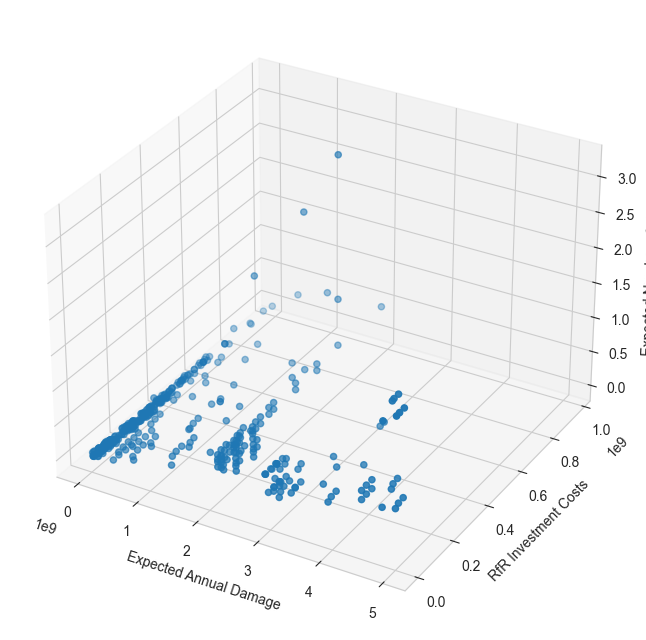

In [21]:
from mpl_toolkits.mplot3d import Axes3D  

outcomes = results_optimization.loc[:, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']]

fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes['Expected Annual Damage'], outcomes['RfR Investment Costs'], outcomes['Expected Number of Deaths'])
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('RfR Investment Costs')
ax.set_zlabel('Expected Number of Deaths')
plt.show()

# Selecting policies within policy vision

Note: These are different for both runs and can vary a bit

In [22]:
import numpy as np

condition_deaths = results_optimization['Expected Number of Deaths'] < 0.3
condition_damage = results_optimization['Expected Annual Damage'] <  1.227898e+05
condition_RfRcosts = results_optimization['RfR Investment Costs'] > 176700000.0
condition_dikecosts = results_optimization['Dike Investment Costs'] < 3.043865e+08

logical = condition_deaths  & condition_damage & condition_RfRcosts &condition_dikecosts 

np.sum(logical)

2

In [23]:
policies = results_optimization[logical]
# policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
# policies['total costs'] = policies['RfR Investment Costs'] + policies['Dike Investment Costs']
policies
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
policies_to_evaluate

[Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 1.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 1.0, '3_RfR 2': 1.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 0.0, 'A.1_DikeIncrease 0': 2.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 0.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 10.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 2.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 1.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 0.0, 'Dike Investment Costs': 113839517.91237941, 'RfR Investment Costs': 624900000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0}),
 Policy({'0_RfR 0': 1.0, '0_RfR 1': 1.0, '0_RfR 2': 1.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2'

Running multiple scenarios over the chosen policies

In [24]:
n_scenarios = 10000
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    results_policies = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 10000 scenarios * 2 policies * 1 model(s) = 20000 experiments
100%|████████████████████████████████████| 20000/20000 [14:04<00:00, 23.67it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Evaluating mean and max values of the policies in all scenarios

In [25]:
experiments, outcomes = results_policies

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

mean_df = all.groupby('policy')[keys].mean()
# mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_57152\1521430147.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
124,1.224235e+08,1.138395e+08,624900000.0,0.00000,0.097882
164,1.124320e+08,1.045854e+08,709500000.0,2403.30816,0.032494


In [26]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_57152\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
124,3.531281e+09,1.138395e+08,624900000.0,0.000000,2.286313
164,3.617233e+09,1.045854e+08,709500000.0,30431.627489,0.752628


Creating mean and max parcoords of the policies

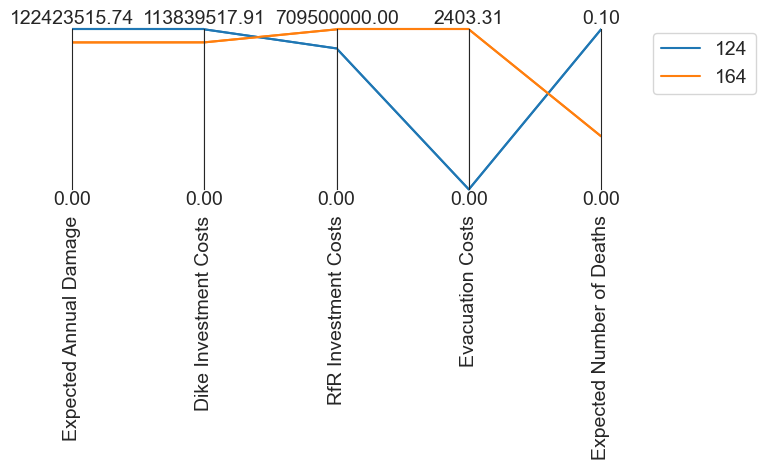

In [27]:
colors = sns.color_palette()
data = mean_df.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

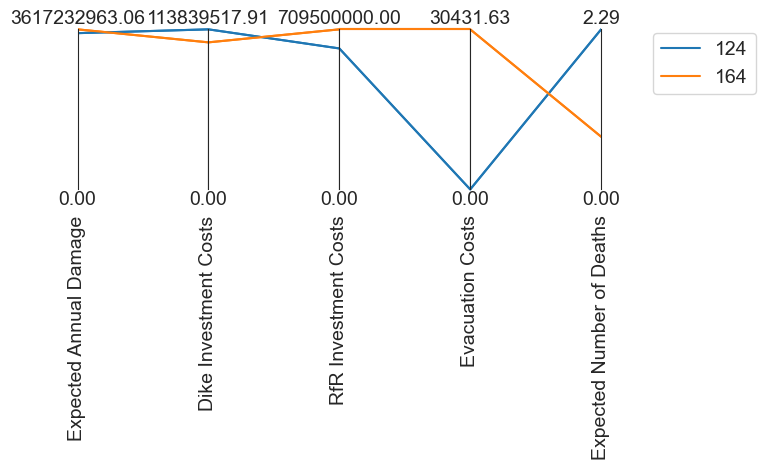

In [28]:
colors = sns.color_palette()
data = max_df.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

C:\Users\svenk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


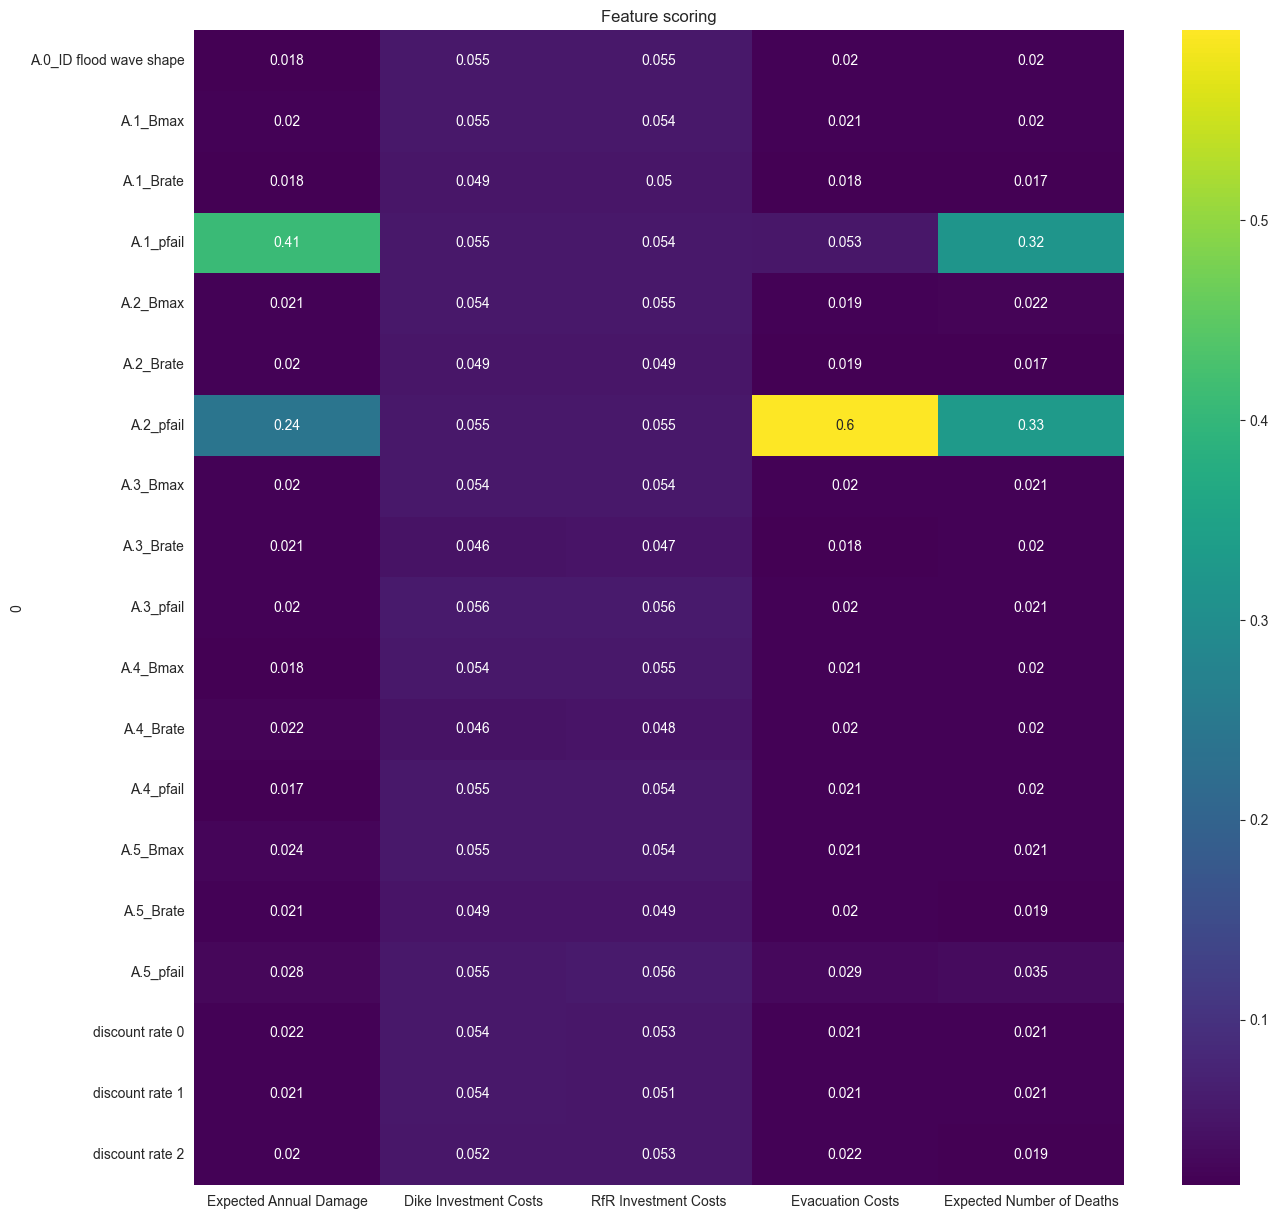

In [30]:
from ema_workbench.analysis import feature_scoring
 
x = experiments
x = experiments.drop(columns=['0_RfR 0',
                          '0_RfR 1',
                          '0_RfR 2',
                          '1_RfR 0',
                          '1_RfR 1',
                          '1_RfR 2',
                          '2_RfR 0',
                          '2_RfR 1',
                          '2_RfR 2',
                          '3_RfR 0',
                          '3_RfR 1',
                          '3_RfR 2',
                          '4_RfR 0',
                          '4_RfR 1',
                          '4_RfR 2',
                          'EWS_DaysToThreat',
                          'A.1_DikeIncrease 0',
                          'A.1_DikeIncrease 1',
                          'A.1_DikeIncrease 2',
                          'A.2_DikeIncrease 0',
                          'A.2_DikeIncrease 1',
                          'A.2_DikeIncrease 2',
                          'A.3_DikeIncrease 0',
                          'A.3_DikeIncrease 1',
                          'A.3_DikeIncrease 2',
                          'A.4_DikeIncrease 0',
                          'A.4_DikeIncrease 1',
                          'A.4_DikeIncrease 2',
                          'A.5_DikeIncrease 0',
                          'A.5_DikeIncrease 1',
                          'A.5_DikeIncrease 2',
                          'policy'
                          ])
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(fs, cmap='viridis', annot=True)

plt.title('Feature scoring')
plt.show()